# ER (Event Rejection) Algorithm

In [1]:
from turtle import title
from h5py import File
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
#Opening the HDF5 File
input_file = "../user.viruelas.27383479._000001.output.h5"
data = File(input_file, 'r')
print("List of available datasets: " + str(list(data.keys())))

List of available datasets: ['fs_tracks', 'fs_tracks_simple_ip', 'jets', 'tracks']


In [3]:
#Accessing the 'Jets' Dataset
jets = data['jets']
print("The attributes of each element of the dataset (jets): " + str(jets.dtype.fields.keys()))

The attributes of each element of the dataset (jets): dict_keys(['pt_btagJes', 'eta_btagJes', 'absEta_btagJes', 'JetFitter_energyFraction', 'JetFitter_mass', 'JetFitter_significance3d', 'JetFitter_deltaphi', 'JetFitter_deltaeta', 'JetFitter_massUncorr', 'JetFitter_dRFlightDir', 'SV1_masssvx', 'SV1_efracsvx', 'SV1_significance3d', 'SV1_dstToMatLay', 'SV1_deltaR', 'SV1_Lxy', 'SV1_L3d', 'JetFitter_deltaR', 'JetFitterSecondaryVertex_displacement3d', 'JetFitterSecondaryVertex_displacement2d', 'JetFitterSecondaryVertex_mass', 'JetFitterSecondaryVertex_energy', 'JetFitterSecondaryVertex_energyFraction', 'JetFitterSecondaryVertex_minimumTrackRelativeEta', 'JetFitterSecondaryVertex_maximumTrackRelativeEta', 'JetFitterSecondaryVertex_averageTrackRelativeEta', 'JetFitterSecondaryVertex_minimumAllJetTrackRelativeEta', 'JetFitterSecondaryVertex_maximumAllJetTrackRelativeEta', 'JetFitterSecondaryVertex_averageAllJetTrackRelativeEta', 'MV2c10_discriminant', 'IP2D_pu', 'IP2D_pc', 'IP2D_pb', 'IP3D_pu',

In [4]:
#Accessing the 'super_tracks' Dataset
jets = data['jets']
print("The attributes of each element of the dataset (jets): " + str(jets.dtype.fields.keys()))

The attributes of each element of the dataset (jets): dict_keys(['pt_btagJes', 'eta_btagJes', 'absEta_btagJes', 'JetFitter_energyFraction', 'JetFitter_mass', 'JetFitter_significance3d', 'JetFitter_deltaphi', 'JetFitter_deltaeta', 'JetFitter_massUncorr', 'JetFitter_dRFlightDir', 'SV1_masssvx', 'SV1_efracsvx', 'SV1_significance3d', 'SV1_dstToMatLay', 'SV1_deltaR', 'SV1_Lxy', 'SV1_L3d', 'JetFitter_deltaR', 'JetFitterSecondaryVertex_displacement3d', 'JetFitterSecondaryVertex_displacement2d', 'JetFitterSecondaryVertex_mass', 'JetFitterSecondaryVertex_energy', 'JetFitterSecondaryVertex_energyFraction', 'JetFitterSecondaryVertex_minimumTrackRelativeEta', 'JetFitterSecondaryVertex_maximumTrackRelativeEta', 'JetFitterSecondaryVertex_averageTrackRelativeEta', 'JetFitterSecondaryVertex_minimumAllJetTrackRelativeEta', 'JetFitterSecondaryVertex_maximumAllJetTrackRelativeEta', 'JetFitterSecondaryVertex_averageAllJetTrackRelativeEta', 'MV2c10_discriminant', 'IP2D_pu', 'IP2D_pc', 'IP2D_pb', 'IP3D_pu',

In [8]:
uniques = np.unique(jets["eventNumber"])
print(np.array(uniques))

[60000001 60000002 60000003 ... 60151998 60151999 60152000]


In [ ]:
#Getting an array of Event_IDs for 4-jet events
uniques = np.unique(jets["eventNumber"])
four_jet_ids = []
counter = 0
for i in uniques:
    if len(jets[jets["eventNumber"] == i]) == 20: 
        four_jet_ids.append(i)
        break;
        counter += 1
    if counter == 100:
        break;

print(four_jet_ids)
print(len(four_jet_ids))

In [28]:
four_jet_event = jets[jets["eventNumber"] == four_jet_ids[0]]
four_jet_event[0]["dipz_z"]

2.465

In [33]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import random
#Generating random colors for  the plot
color=["#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)])
           for j in range(len(four_jet_event))]
ic = 0      #color counter

for i in range(len(four_jet_event)):
    plt.plot(x, norm.pdf(x, four_jet_event[i]["dipz_z"], np.exp(-0.5*four_jet_event[i]["dipz_negLogSigma2"])), color=color[ic], linewidth=2, label='Jet '+str(ic))
    ic = ic + 1    
plt.xlabel("z/50 mm", loc='right')
plt.title('The regressed z-position of some jets')
plt.xlim([-4, 4])
plt.legend()
plt.show()
#plt.cla()

NameError: name 'x' is not defined

In [27]:
super_tracks = data['super_tracks']
print("The attributes of each element of the dataset (super_tracks): " + str(super_tracks.dtype.fields.keys()))

The attributes of each element of the dataset (super_tracks): dict_keys(['numberOfInnermostPixelLayerHits', 'numberOfNextToInnermostPixelLayerHits', 'numberOfPixelHits', 'numberOfSCTHits', 'numberOfPixelHoles', 'numberOfSCTHoles', 'chiSquared', 'numberDoF', 'radiusOfFirstHit', 'qOverP', 'pt', 'ptfrac', 'qOverPUncertainty', 'd0', 'd0Uncertainty', 'IP2D_signed_d0', 'phiUncertainty', 'thetaUncertainty', 'deta', 'dphi', 'dr', 'z0RelativeToBeamspot', 'z0RelativeToBeamspotUncertainty', 'valid'])


In [28]:
print(super_tracks['z0RelativeToBeamspot'])

[[ 37.13629    37.253117   40.838814  ...         nan         nan
          nan]
 [-30.690022   38.180237   50.051197  ...         nan         nan
          nan]
 [  5.6123476 -24.55395   -33.712482  ...         nan         nan
          nan]
 ...
 [  7.3150687  26.28233    12.656669  ...         nan         nan
          nan]
 [  9.174093    9.1709385   9.12646   ...         nan         nan
          nan]
 [-57.978844   60.228466   -8.469741  ...         nan         nan
          nan]]


In [29]:
print(np.sum(jets['n_super_tracks'] == 0))

2


In [30]:
print(len(jets))

116


In [31]:
print(z.shape)

(116,)


In [32]:
print(jets)

<HDF5 dataset "jets": shape (116,), type "|V92">


In [33]:
print(z[0])

0.74848443


In [34]:
print(jets['dipz20230223_z'][0])

0.7484845


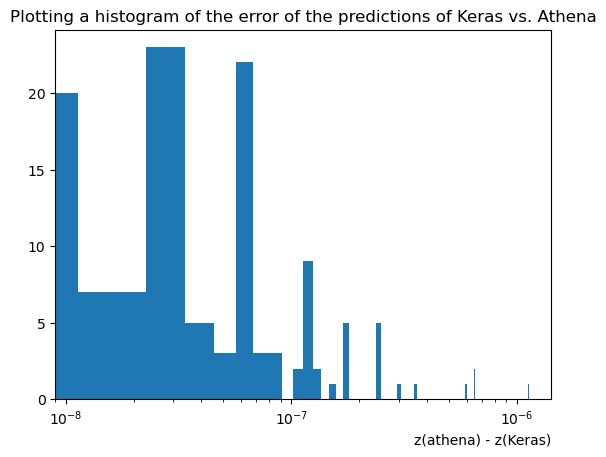

In [35]:
plt.hist(np.abs(jets['dipz20230223_z']-z), bins=100)
plt.xscale('log')
plt.title('Plotting a histogram of the error of the predictions of Keras vs. Athena')
plt.xlabel("z(athena) - z(Keras)", loc='right')
plt.show()

2


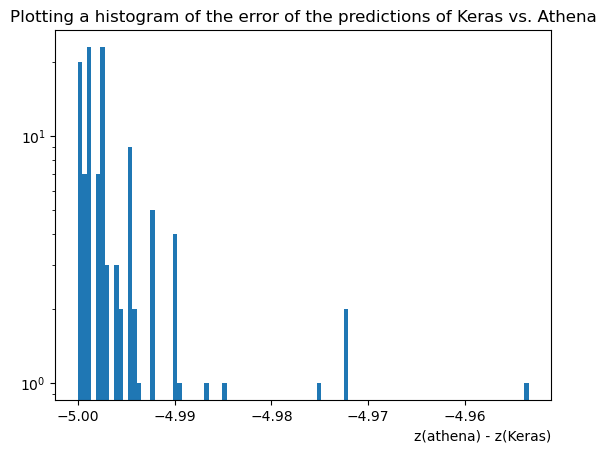

In [36]:
سين = 2
print(سين)
plt.hist(np.log10(np.abs(jets['dipz20230223_z']-z) + 10**-5), bins=100)
plt.yscale('log')
plt.title('Plotting a histogram of the error of the predictions of Keras vs. Athena')
plt.xlabel("z(athena) - z(Keras)", loc='right')
plt.show()

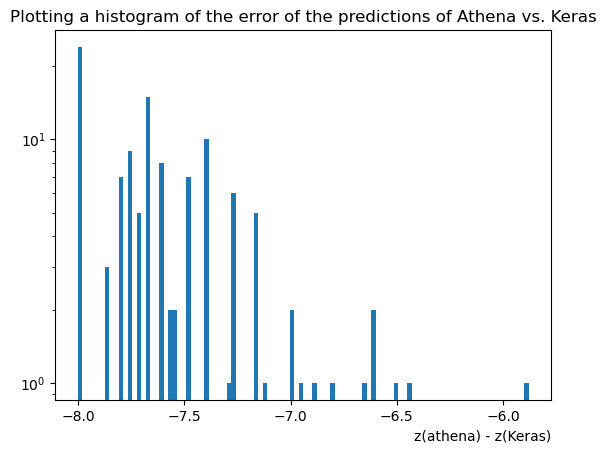

In [37]:
c = np.sqrt(np.exp(-jets['dipz20230223_negLogSigma2']))-widths
plt.hist(np.log10(np.abs(c) + 10**-8), bins=100)
plt.yscale('log')
plt.title('Plotting a histogram of the error of the predictions of Athena vs. Keras')
plt.xlabel("z(athena) - z(Keras)", loc='right')
plt.show()

In [38]:
c2 = np.sqrt(np.exp(-jets['dipz_negLogSigma2']))-widths
plt.hist(c2, bins=100)
plt.yscale('log')
plt.title('Plotting a histogram of the error of the Uncertainty of Athena vs. Keras')
plt.xlabel("std(athena) - std(Keras)", loc='right')
plt.show()

ValueError: Field dipz_negLogSigma2 does not appear in this type.

In [ ]:
jets['dipz20230223_z'].mean()

In [ ]:
plt.hist(jets['dipz20230223_z'], bins=100)
#plt.yscale('log')
plt.show()

In [ ]:
plt.hist(zhat, bins=100)
#plt.yscale('log')
plt.show()

In [ ]:
plt.hist(jets['dipz20230223_z']-zhat, bins=100)
plt.yscale('log')
plt.show()

In [ ]:
"""Plotting a histogram of the error of z-positions predictionof all jets"""
plt.hist(zhat-z, bins=100)
plt.yscale('log')
plt.title('Plotting a histogram of the error of z-positions prediction of all jets')
plt.xlabel("|z\u0302 - z|", loc='right')
plt.show()

In [ ]:
plt.hist(jets['dipz20230223_z']-z, bins=100)
plt.yscale('log')
plt.title('Plotting a histogram of the error of the predictions')
#plt.xlabel("|z\u0302 - z|", loc='right')
plt.show()

In [ ]:
d = jets['dipz20230223_z']-z
c = d > 0.01 
print(len(d))
print(np.count_nonzero(c))

In [ ]:
regions = [1,10**-1,10**-2,10**-3,10**-4,10**-5,10**-6,10**-7,10**-8,10**-9,10**-10]
for i in regions:
    c = c1 > i 
    n = np.count_nonzero(c)
    print("The number of predictions with error in calculating z bigger than " + str(i) + " is " + str(n))

In [ ]:
s = jets['dipz20230223_negLogSigma2']-widths
max = np.argmax(s)

In [ ]:
jet_intended = jets[max]
jet_variables = ['pt', 'HadronConeExclTruthLabelPt', 'n_tracks_nn', 'eta', 
                 'fastDips_pb', 'fastDips_pc', 'fastDips_pu', 'dipz_z', 'dipz_negLogSigma2', 
                 'HadronConeExclTruthLabelID', 'HadronConeExclExtendedTruthLabelID', 'jetPtRank', 
                 'n_super_tracks', 'n_super_tracks_associated', 'n_super_tracks_fixed_cone', 'mcEventWeight', 
                 'eventNumber', 'averageInteractionsPerCrossing', 'actualInteractionsPerCrossing', 
                 'nPrimaryVertices', 'primaryVertexDetectorZ', 'primaryVertexDetectorZUncertainty']
for var in jet_variables:
    c = jet_intended[var]
    print("The jet's " + var + " is " + str(c))

In [ ]:
idx = jets['n_super_tracks'] < 40
c = jets['dipz20230223_z']-z
plt.hist(np.log10(np.abs(c[idx])+ 1e-10) , bins=500)
plt.yscale('log')
plt.title('Plotting a histogram of the error of the predictions of Keras vs. Athena')
plt.xlabel("z(athena) - z(Keras)", loc='right')
plt.show()

In [ ]:
plt.hist(jets['primaryVertexDetectorZ'], bins=100)
#plt.yscale('log')
plt.show()

In [ ]:
j = jets['primaryVertexDetectorZ'].astype('float64')
print("The target's mean is: " + str(j.mean()))
print("The target's std is: " + str(j.std()))